In [2]:
import numpy as np
import itertools
import time
from scipy.sparse.linalg import gmres, LinearOperator
from multiprocessing import Pool, cpu_count
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import scipy.sparse as sp
import scipy.sparse.linalg as spla

start_time = time.time()
# ---------------- model parameters --------------
# Example parameters
# 3 queues, arrival probs 0.1,0.3,0.4
# 1 server
# queue-length cap N=50
# boundary penalty M=200000
# discount factor beta=0.99
p = [0.1,0.3,0.4]   # arrival probs for each queue
R = 1                  # number of servers
Q = len(p)             # number of queues
beta = 0.99            # discount factor
N = 50                 # queue-length cap
M = 200000             # boundary penalty (set 0 if you don't want it)

# ----- queue index helpers (unchanged) ----------
def encode_queue(q):
    """Encode queue-length vector q (length Q) to integer in [0, (N+1)^Q - 1]."""
    idx_q = 0
    for x in q:
        idx_q = idx_q * (N + 1) + x
    return idx_q

def decode_queue(idx_q):
    """Inverse of encode_queue."""
    q = [0] * Q
    for j in range(Q - 1, -1, -1):
        q[j] = idx_q % (N + 1)
        idx_q //= (N + 1)
    return q

NUM_Q_STATES = (N + 1) ** Q

# ----- ROBOT (SERVER) STATE COMPRESSION ----------
# We only allow *distinct* server positions: no two servers in the same queue.
# So robot-states are permutations of Q taken R at a time.

robot_states = list(itertools.permutations(range(Q), R))
NUM_R_STATES = len(robot_states)

# Map each robot-position tuple to an index 0..NUM_R_STATES-1
robot_index = {s: i for i, s in enumerate(robot_states)}

def encode_robots(s):
    """Encode robot position tuple s (length R, distinct entries) to 0..NUM_R_STATES-1."""
    return robot_index[tuple(s)]

def decode_robots(g):
    """Inverse of encode_robots."""
    return list(robot_states[g])

# ----- GLOBAL STATE INDEXING (COMPRESSED) -------
# A global state is (s, q) where:
#   s in robot_states (distinct server positions),
#   q in {0,...,N}^Q.

def idx(s, q):
    """Encode (s,q) to global state index k in [0,S-1]."""
    r_idx = encode_robots(s)
    q_idx = encode_queue(q)
    return r_idx * NUM_Q_STATES + q_idx

def decode(k):
    """Inverse: k -> (s, q)."""
    r_idx, q_idx = divmod(k, NUM_Q_STATES)
    s = decode_robots(r_idx)
    q = decode_queue(q_idx)
    return s, q

S = NUM_R_STATES * NUM_Q_STATES  # total number of *legal* states
print("Total states S =", S)

# ----- Actions -----
# Per server:
#   0        : "serve/stay" (if queue > 0, serve; else stay)
#   1..Q     : "switch to queue j" (1 -> Q0, 2 -> Q1, ..., Q -> Q(Q-1))

A = {0: "serve"}
for j in range(Q):
    A[1 + j] = f"switch_to_Q{j+1}"

# ----- Arrival tuples (2^Q possibilities) -------
start_time = time.time()

arr = []
for a in itertools.product((0, 1), repeat=Q):
    pr = 1.0
    for aj, pj in zip(a, p):
        pr *= pj if aj else (1 - pj)
    arr.append((a, pr))

# ----- One-step dynamics ------------------------
def nxt(s, q, a):
    """
    Given state (s,q) and joint action a (len R), return list of
    (prob, s', q') transitions.
    """
    out = []
    for a_vec, pr in arr:
        nq = list(q)
        ns = list(s)
        # Service / switching by each server
        for r in range(R):
            if a[r] == 0:
                # serve (only allowed if own queue > 0)
                if nq[ns[r]] > 0:
                    nq[ns[r]] -= 1
            elif 1 <= a[r] <= Q:
                # switch to given queue (travel, no service)
                target = a[r] - 1
                ns[r] = target
        # Arrivals with truncation
        for j in range(Q):
            nq[j] = min(nq[j] + a_vec[j], N)

        # ns is guaranteed to have distinct entries if 'a' is admissible_multi
        out.append((pr, tuple(ns), tuple(nq)))
    return out

# ----- Admissible joint actions (multi-server) ---
def admissible_multi(r, q):
    """
    Given server positions r (len R) and queue lengths q (len Q),
    return the list of admissible joint actions a (len R),
    with constraints:
      - If q[pos] > 0, that server's local action set = {0} (serve).
      - If q[pos] == 0, local actions = {0} U {switch to any other queue}.
      - No two servers may end up on the same queue (no collisions).
      - (Optional) global constraints you had before on histogram transitions.
    """
    r = np.asarray(r)
    q = np.asarray(q)
    M_serv = r.shape[0]
    Q_loc = q.shape[0]

    # Local actions per server
    local_actions = []
    for m in range(M_serv):
        pos = int(r[m])
        if q[pos] > 0:
            acts = (0,)
        else:
            acts = (0,) + tuple(1 + j for j in range(Q_loc) if j != pos)
        local_actions.append(acts)

    # Current histogram of server positions
    hist_current = np.bincount(r, minlength=Q_loc)

    joint_actions = []
    for a_tuple in itertools.product(*local_actions):
        dest = []
        for m, a in enumerate(a_tuple):
            pos = int(r[m])
            if a == 0:
                dest.append(pos)
            else:
                dest.append(a - 1)

        # No collisions in next positions
        if len(set(dest)) != M_serv:
            continue

        # (Optional) forbid histogram-preserving but nontrivial permutations:
        hist_next = np.bincount(dest, minlength=Q_loc)
        if np.array_equal(hist_next, hist_current) and tuple(dest) != tuple(r):
            continue

        joint_actions.append(a_tuple)

    return joint_actions

def _precompute_state(k):
    """
    Run in a worker process: given flat index k, return all
    the precomputed pieces for that state.
    """
    s, q = decode(k)                 # uses your existing decode
    s_t = tuple(s)
    q_t = tuple(q)
    boundary = (max(q) == N)
    g = sum(q)
    acts = admissible_multi(s, q)    # uses your existing admissible_multi
    return (s_t, q_t, boundary, g, acts)

def greedy_longest_no_collision(s, queues):
    """
    Deterministic baseline for the PI model:
      1) For each robot, if its current queue has work and is not already reserved, set STAY (serve).
      2) For remaining robots, greedily assign distinct longest queues (by length),
         tie-break by higher arrival rate p[j], then by lower index.
      3) If nothing to do, STAY (do nothing).

    Action coding: 0=stay (serve if non-empty, else do nothing), 1..Q=switch_to_Q(j).
    """
    s = np.asarray(s, dtype=np.int64)
    queues = np.asarray(queues, dtype=float)
    M = s.shape[0]
    Q = queues.shape[0]

    actions = np.zeros(M, dtype=np.int64)  # default: stay (0)
    reserved_q = set()
    assigned_r = set()
    all_empty = np.all(queues == 0)

    # Pass 1: stay/serve locally if possible (and not already reserved)
    # print(f"Pass 1: stay/serve locally if possible (and not already reserved)")
    for r in range(M):
        loc = int(s[r])
        if queues[loc] > 0 and loc not in reserved_q:
            actions[r] = 0  # stay/serve
            reserved_q.add(loc)
            assigned_r.add(r)
            # print(f"Robot {r} assigned to queue {loc} with action {actions[r]}")

    # Pass 2: assign longest remaining queues to unassigned robots
    # print(f"Pass 2: assign longest remaining queues to unassigned robots")
    for r in range(M):
        if r in assigned_r:
            continue
        pos_cands = [j for j in range(Q) if j not in reserved_q]

        if all_empty:
            # Don’t chase queues already occupied by other robots when all queues are empty
            occupied_by_others = set(map(int, s))
            occupied_by_others.discard(int(s[r]))
            pos_cands_no_others = [j for j in pos_cands if j not in occupied_by_others]
            if pos_cands_no_others:
                pos_cands = pos_cands_no_others

        if len({(queues[j], p[j]) for j in pos_cands}) == 1:
            reserved_q.add(int(s[r]))
            actions[r] = 0
        else:
            j_best = max(pos_cands, key=lambda j: (queues[j], p[j]))
            if j_best != s[r]:
                actions[r] = 1 + j_best
                reserved_q.add(j_best)
            else:
                actions[r] = 0
                reserved_q.add(int(s[r]))
    return actions

# Single-step environment transition given arrivals
def step_env(r, q, a, arrivals):

    r_new = list(r)
    q_new = list(q)

    # service / movement
    for m in range(len(r_new)):
        act = int(a[m])
        pos = r_new[m]
        if act == 0:  # stay: serve if non-empty, else do nothing
            if q_new[pos] > 0:
                q_new[pos] -= 1
        elif 1 <= act <= Q:  # switch to queue (act-1)
            r_new[m] = act - 1

    # arrivals (truncate at N)
    for j in range(Q):
        q_new[j] = min(q_new[j] + arrivals[j], N)

    return tuple(r_new), tuple(q_new)

# -------- PRECOMPUTATION ------------------------
if __name__ == "__main__":
    start_time = time.time()
    g_bar = np.zeros(S, dtype=float)
    decodes_list = [None] * S
    is_boundary = np.zeros(S, dtype=bool)
    admissible_actions_list = [None] * S
    nxt_table = [None] * S

    # CHUNK_SIZE = 100
    CHUNK_SIZE = int(S/(mp.cpu_count()*4))
    # CHUNK_SIZE = 1000000

    # Parallel map over all k
    ctx = mp.get_context("fork")  # use fork instead of spawn
    with ProcessPoolExecutor(mp_context=ctx) as ex:
        results = list(ex.map(_precompute_state, range(S), chunksize=CHUNK_SIZE))

    # Unpack results back into your arrays
    for k, (s_t, q_t, boundary, g, acts) in enumerate(results):
        decodes_list[k] = (s_t, q_t)
        is_boundary[k] = boundary
        g_bar[k] = g
        admissible_actions_list[k] = acts

    print(f"State info precomputation done in {time.time() - start_time:.2f} seconds.")

    start_time = time.time()

    def _precompute_transitions(chunk_indices):
        out = []
        for k in chunk_indices:
            s, q = decodes_list[k]
            d = {}
            for a in admissible_actions_list[k]:
                d[a] =[(pr, idx(ns, nq)) for pr, ns, nq in nxt(s, q, a)]
            out.append((k, d))
        return out

    chunks = [range(i, min(i + CHUNK_SIZE, S)) for i in range(0, S, CHUNK_SIZE)]

    ctx = mp.get_context("fork")  # use fork instead of spawn
    with ProcessPoolExecutor(mp_context=ctx) as ex:
        for batch in ex.map(_precompute_transitions, chunks):
            for k, d in batch:
                nxt_table[k] = d

    print(f"Transition table precomputation done in {time.time() - start_time:.2f} seconds.")
    
    # -------- POLICY ITERATION ----------------------
    V = np.zeros(S)
    pol = np.zeros((S, R), dtype=int)

    # Initialize policy: pick first admissible action at each state
    for k in range(S):
        # pol[k] = np.array(admissible_actions_list[k][0])
        pol[k] = np.array(greedy_longest_no_collision(decodes_list[k][0], decodes_list[k][1]))

    stable = False
    max_outer_iters = 20

    for it in range(max_outer_iters):
        if stable:
            break
        print(f"\n=== Policy iteration outer loop {it+1} ===")
        # (i) Policy evaluation via matrix-free GMRES:
        # def matvec(x):
        #     out = np.empty_like(x)
        #     for k in range(S):
        #         acc = x[k]
        #         a_tuple = tuple(int(a) for a in pol[k])
        #         for pr, s_next in nxt_table[k][a_tuple]:
        #             acc -= beta * pr * x[s_next]
        #         out[k] = acc
        #     return out

        # Aop = LinearOperator((S, S), matvec=matvec, dtype=float)
        # # Right-hand side: g_bar + M * 1_{boundary}
        # rhs = g_bar + M * is_boundary.astype(float)

        # print("  Solving (I - beta P_pi) V = g_bar + M*1_boundary with GMRES...")
        # V, info = gmres(Aop, rhs, rtol=1e-4, restart=200, maxiter=200)
        def build_policy_matrix(pol):
            rows, cols, data = [], [], []
            for k in range(S):
                rows.append(k); cols.append(k); data.append(1.0)  # diagonal
                a = tuple(pol[k])
                for pr, s_next in nxt_table[k][a]:
                    rows.append(k); cols.append(s_next); data.append(-beta * pr)
            return sp.csr_matrix((data, (rows, cols)), shape=(S, S))

        Aop = build_policy_matrix(pol)
        rhs = g_bar + M * is_boundary.astype(float)
        # Optional Jacobi preconditioner
        Dinv = 1.0 / Aop.diagonal()
        Mjac = spla.LinearOperator(Aop.shape, matvec=lambda x: Dinv * x)
        V, info = spla.gmres(Aop, rhs, M=Mjac, rtol=1e-4, restart=200, maxiter=200)
        assert info == 0, f"GMRES did not converge, info={info}"

        # (ii) Policy improvement
        print("  Improving policy...")
        stable = True
        updates = 0
        
        cnt = 0
        for k in range(S):
            s, q = decodes_list[k]
            best = pol[k].copy()
            best_val = np.inf
            for a in admissible_actions_list[k]:
                q_val = (g_bar[k] + (M if is_boundary[k] else 0.0) +
                            beta * sum(pr * V[s_next] for pr, s_next in nxt_table[k][a]))
                if q_val < best_val - 1e-4:
                    best_val = q_val
                    best = np.array(a)

            if not np.array_equal(best, pol[k]):
                # if cnt <= 3:
                #     cnt += 1
                #     print(f"State {k} ({s},{q}): improving action {pol[k]} -> {best}, value from {V[k]:.2f} -> {best_val:.2f}")
                pol[k] = best
                stable = False
                updates += 1

        print(f"  Policy improvement updates: {updates}")
        if stable:
            print("  Policy is stable. Stopping.")

    print("Policy iteration finished.")
    print(f"Execution time: {time.time() - start_time:.2f} seconds")

    # -------- SIMULATION COMPARISON --------------

    num_episodes = 1000
    max_steps = 5000

    rng = np.random.default_rng(seed=123)  # no seed -> different episodes naturally
    # arrivals_all[ep, t, j] is arrival (0/1) to queue j at time t in episode ep
    arrivals_all = rng.binomial(1, p, size=(num_episodes, max_steps, Q))
    # print(arrivals_all)

    # for ep in range(num_episodes):

    def simulate_episode(ep):
        # optimal policy episode
        r = np.arange(R)
        q = [0] * Q
        G_opt = 0.0
        disc = 1.0
        for t in range(max_steps):
            a = pol[idx(r, q)]
            cost = sum(q)
            if max(q) == N:
                cost += M
            G_opt += disc * cost
            disc *= beta
            arrivals = arrivals_all[ep, t]
            r, q = step_env(r, q, a, arrivals)

        # greedy policy episode, same arrival sample path
        r = np.arange(R)
        q = [0] * Q
        G_greedy = 0.0
        disc = 1.0
        for t in range(max_steps):
            a = greedy_longest_no_collision(r, q)
            cost = sum(q)
            if max(q) == N:
                cost += M
            G_greedy += disc * cost
            disc *= beta
            arrivals = arrivals_all[ep, t]
            r, q = step_env(r, q, a, arrivals)
        
        return G_opt, G_greedy
    
    ctx = mp.get_context("fork")
    with ProcessPoolExecutor(mp_context=ctx) as ex:
        results = list(ex.map(simulate_episode, range(num_episodes)))
    returns_opt, returns_greedy = map(np.array, zip(*results))

    diff = returns_opt - returns_greedy  # negative means optimal is better
    print("optimal returns:", returns_opt.mean())
    print("greedy returns:", returns_greedy.mean())
    print("Mean difference (optimal - greedy):", diff.mean())

Total states S = 397953
State info precomputation done in 0.85 seconds.
Transition table precomputation done in 1.30 seconds.

=== Policy iteration outer loop 1 ===
  Improving policy...
  Policy improvement updates: 853

=== Policy iteration outer loop 2 ===
  Improving policy...
  Policy improvement updates: 72

=== Policy iteration outer loop 3 ===
  Improving policy...
  Policy improvement updates: 0
  Policy is stable. Stopping.
Policy iteration finished.
Execution time: 43.04 seconds
optimal returns: 418.1795927986726
greedy returns: 423.3561769005313
Mean difference (optimal - greedy): -5.176584101858691


/var/folders/hv/5454gsds1z77zpwrr44ydtcm0000gn/T/ipykernel_50961/2064670967.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


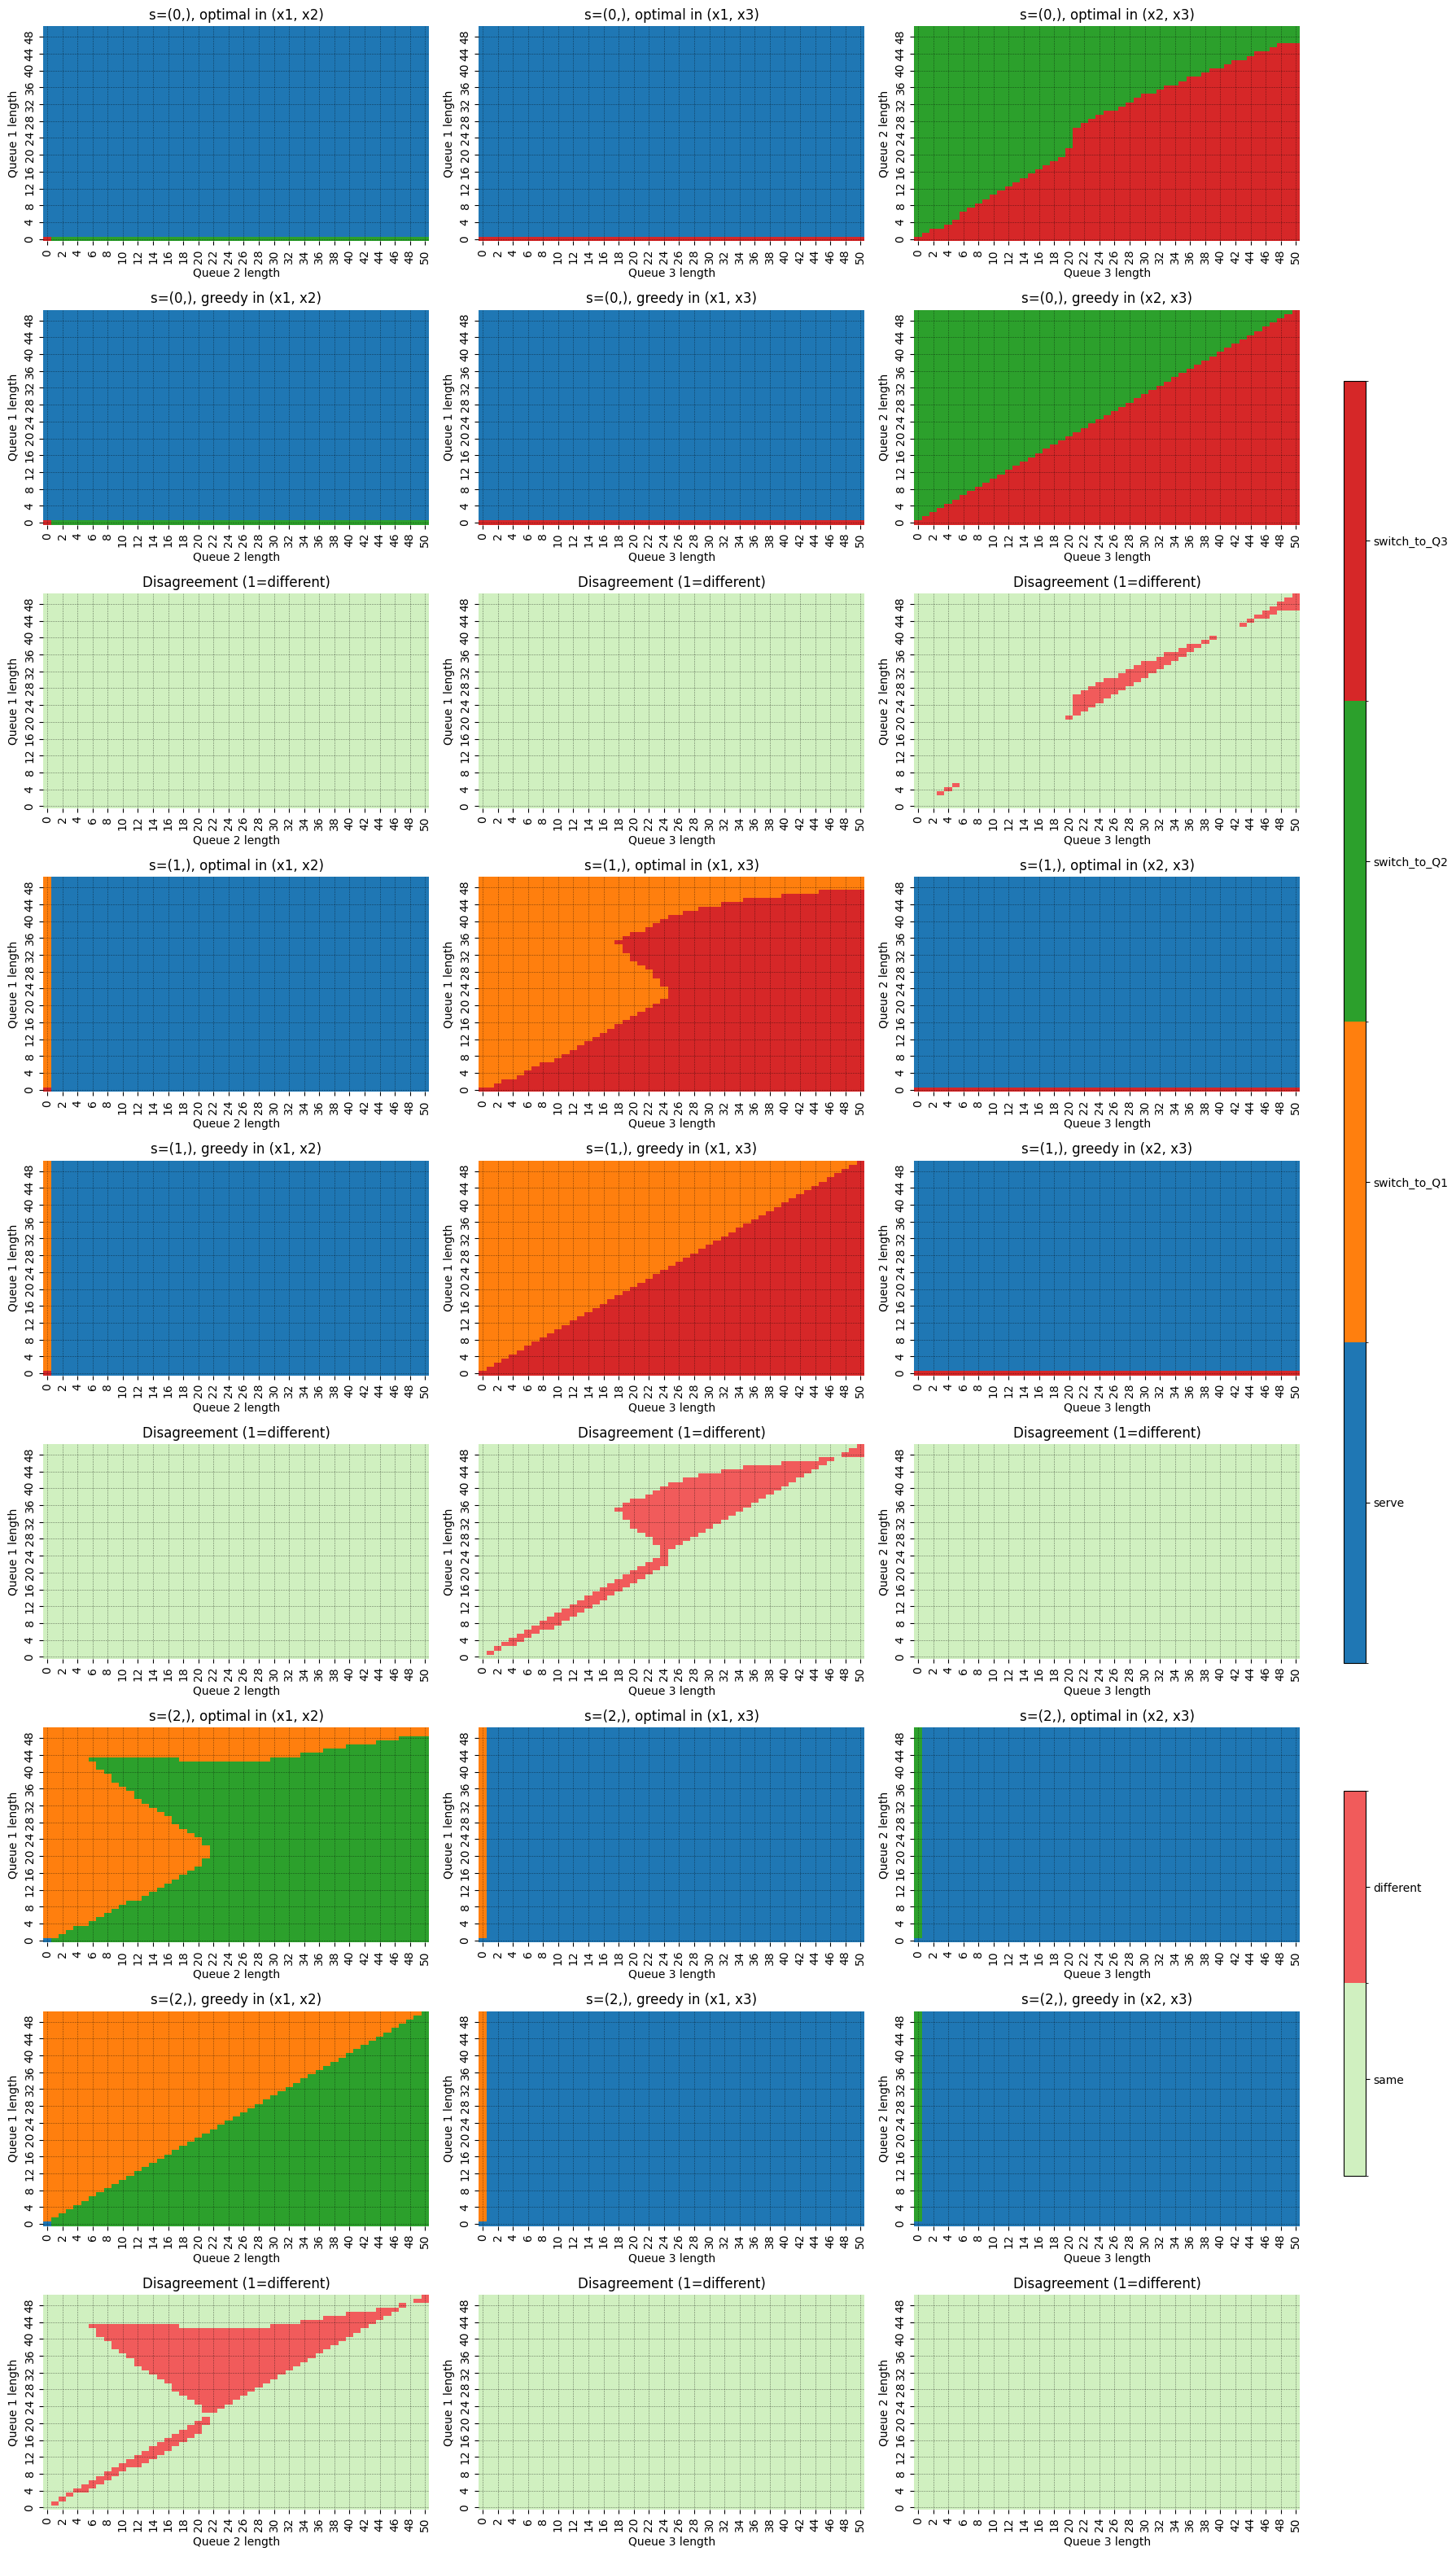

In [3]:
# --- Compare optimal policy vs greedy_longest_no_collision ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase

pair_configs = [(i, j) for i in range(Q) for j in range(i + 1, Q)]
num_pairs = len(pair_configs)

if num_pairs == 0:
    print("No 2D slices to visualize (Q < 2).")
else:
    # Build a common action mapping across optimal and greedy for consistent colors
    all_actions = set()
    for s in robot_states:
        for v1 in range(N + 1):
            for v2 in range(N + 1):
                # collect actions for ALL pair configurations (not only the first)
                for (i1, i2) in pair_configs:
                    q = [0] * Q
                    q[i1] = v1
                    q[i2] = v2
                    k = idx(s, q)
                    all_actions.add(tuple(map(int, pol[k])))
                    all_actions.add(tuple(map(int, greedy_longest_no_collision(s, q))))
    all_actions = sorted(all_actions)
    action_labels = [" | ".join(A[int(x)] for x in act) for act in all_actions]
    action_mapping = {act: idx for idx, act in enumerate(all_actions)}
    num_actions = len(all_actions)

    base_colors = sns.color_palette("tab10", n_colors=min(10, num_actions))
    if num_actions > 10:
        extra_colors = sns.color_palette("husl", n_colors=num_actions - 10)
        colors = list(base_colors) + list(extra_colors)
    else:
        colors = base_colors
    cmap = mcolors.ListedColormap(colors[:num_actions])
    bounds = np.arange(-0.5, num_actions + 0.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    diff_cmap = mcolors.ListedColormap(["#d0f0c0", "#f15b5b"])  # same, different
    diff_bounds = np.arange(-0.5, 2.5, 1)
    diff_norm = mcolors.BoundaryNorm(diff_bounds, diff_cmap.N)

    rows_per_state = 3  # optimal, greedy, disagreement
    fig, axes = plt.subplots(rows_per_state * len(robot_states), num_pairs,
                             figsize=(6 * num_pairs, 3.5 * rows_per_state * len(robot_states)))
    axes = np.array(axes).reshape(rows_per_state * len(robot_states), num_pairs)

    for r_idx, s in enumerate(robot_states):
        for j, (i1, i2) in enumerate(pair_configs):
            opt_vals = np.zeros((N + 1, N + 1), dtype=int)
            greedy_vals = np.zeros((N + 1, N + 1), dtype=int)

            for v1 in range(N + 1):
                for v2 in range(N + 1):
                    q = [0] * Q
                    q[i1] = v1
                    q[i2] = v2
                    k = idx(s, q)

                    act_opt = tuple(map(int, pol[k]))
                    act_g = tuple(map(int, greedy_longest_no_collision(s, q)))

                    opt_vals[v1, v2] = action_mapping[act_opt]
                    greedy_vals[v1, v2] = action_mapping[act_g]

            diff_mask = (opt_vals != greedy_vals).astype(int)

            row_base = r_idx * rows_per_state
            ax_opt = axes[row_base, j]
            ax_gr = axes[row_base + 1, j]
            ax_diff = axes[row_base + 2, j]

            sns.heatmap(opt_vals, ax=ax_opt, cmap=cmap, norm=norm, cbar=False)
            sns.heatmap(greedy_vals, ax=ax_gr, cmap=cmap, norm=norm, cbar=False)
            sns.heatmap(diff_mask, ax=ax_diff, cmap=diff_cmap, norm=diff_norm, cbar=False)

            ax_opt.set_title(f"s={s}, optimal in (x{i1+1}, x{i2+1})")
            ax_gr.set_title(f"s={s}, greedy in (x{i1+1}, x{i2+1})")
            ax_diff.set_title("Disagreement (1=different)")

            for ax in (ax_opt, ax_gr, ax_diff):
                ax.set_xlabel(f"Queue {i2 + 1} length")
                ax.set_ylabel(f"Queue {i1 + 1} length")
                ax.invert_yaxis()
                ax.grid(color="black", linestyle="--", linewidth=0.4, alpha=0.5)

    # Shared colorbars
    cbar_ax = fig.add_axes([0.92, 0.35, 0.015, 0.5])
    ColorbarBase(cbar_ax, cmap=cmap, norm=norm, boundaries=bounds)
    cbar_ax.set_yticks(range(num_actions))
    cbar_ax.set_yticklabels(action_labels)
    diff_cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.15])
    ColorbarBase(diff_cbar_ax, cmap=diff_cmap, norm=diff_norm, boundaries=diff_bounds)
    diff_cbar_ax.set_yticks([0, 1])
    diff_cbar_ax.set_yticklabels(["same", "different"])
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()